 # Polynomial Regression

In [1]:
import numpy as np
import itertools
import functools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

In [2]:
def normalize(X):
    X_mean = np.mean(X[:,1:], axis=0)
    X_std = np.std(X[:,1:], axis=0)
    X_norm = np.zeros_like(X)
    X_norm[:,0] = X[:,0]
    X_norm[:,1:] = (X[:,1:] - X_mean) / X_std
    return X_norm

In [3]:
class PolynomialTransform:
    @staticmethod
    def combinations(X, degree):
        return itertools.combinations_with_replacement(X, degree)
    @staticmethod
    def compute_new_features(items):
        return functools.reduce(lambda x, y: x * y, items)
    @staticmethod
    def fit_transform(X, degree):
        if X.ndim == 1:
            X = X[:, None]
        features = [np.ones(len(X))]
        for degree in range(1, degree + 1):
            for item in PolynomialTransform.combinations(X.T, degree):
                features.append(PolynomialTransform.compute_new_features(item))
        return np.asarray(features).T

In [4]:
class Random_Data:
    def __init__(self, num_features, num_samples, degree=2, noise_std=1.0):
        self.num_features = num_features
        self.num_samples = num_samples
        self.degree = degree
        self.noise_std = noise_std
    @staticmethod
    def nonlinear(x):
        return np.sin(2 * np.pi * x)
    def generate_nonlinear_data(self, func):
        X = np.linspace(0, 1, self.num_samples)
        y = func(X) + np.random.normal(scale=self.noise_std, size=X.shape)
        return X, y
    def data(self):
        return self.generate_nonlinear_data(self.nonlinear)

In [5]:
def train_test_split(X, y, test_size=None, train_size=None):
    if test_size is None and train_size is None:
        test_size = 0.25
    if train_size is None:
        train_size = 1 - test_size
    arr_rand = np.random.rand(len(X))
    mask = arr_rand < np.percentile(arr_rand, int(train_size * 100))
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[~mask]
    y_test = y[~mask]
    return X_train, X_test, y_train, y_test

In [6]:
class PolynomialRegression:
    def __init__(self, X, y, alpha=1e-2, degree=2, reg=None, lambda_reg=1.0):
        self.X = PolynomialTransform.fit_transform(X, degree)
        self.y = y.reshape(-1, 1)
        self.alpha = alpha
        self.degree = degree
        self.reg = reg
        self.lambda_reg = lambda_reg
        self.Theta = np.ones(shape=(self.X.shape[1], 1), dtype='float64')
        self.m = len(X)
    def reg_term(self, theta):
        if self.reg is None:
            return np.zeros(theta.shape)
        if self.reg == 'l1':
            lasso_reg_term = (self.lambda_reg / self.m) * np.sign(theta)
            lasso_reg_term[0] = 0
            return lasso_reg_term
        ridge_reg_term = (self.lambda_reg / self.m) * theta
        ridge_reg_term[0] = 0
        return ridge_reg_term
    def batch_gradient_descent(self, num_iter):
        iterations = 0
        while iterations < num_iter:
            loss_derivative = (self.X.T @ ((self.X @ self.Theta) - self.y)) / self.m
            loss_derivative += self.reg_term(self.Theta) / self.m
            if np.linalg.norm(loss_derivative) < 1e-5:
                break
            self.Theta = self.Theta - (self.alpha * loss_derivative)
            iterations += 1
        print('Iterations: ', iterations)
    def predict(self, X):
        X_norm = (PolynomialTransform.fit_transform(X, self.degree))
        y = X_norm @ self.Theta
        return y
    def plot(self):
        sns.scatterplot(x=self.X.reshape(-1), y=self.y.reshape(-1))
        plt.plot(self.X.reshape(-1), (self.predict(self.X)).reshape(-1), color='red')
    def plot_test(self, X_test, y_test):
        sns.scatterplot(x=X_test, y=y_test)
        plt.plot(X_test, self.predict(X_test), color='red')
    def weight_vector(self):
        return self.Theta
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test).reshape(-1)
        SS_tot = ((y_test - np.mean(y_test)) ** 2).sum()
        SS_res = ((y_test - y_pred) ** 2).sum()
        r2_score = 1 - SS_res / SS_tot
        return r2_score

In [7]:
X, y = Random_Data(num_features=1, num_samples=500, noise_std=0.5).data()

In [8]:
X[:5]

array([0.        , 0.00200401, 0.00400802, 0.00601202, 0.00801603])

In [9]:
y[:5]

array([-0.33413197,  0.00154237,  0.52114148,  0.57600279, -0.46654416])

In [10]:
X.shape, y.shape

((500,), (500,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [12]:
X_train[:5]

array([0.        , 0.00200401, 0.00400802, 0.00601202, 0.00801603])

In [13]:
X_test[:5]

array([0.01402806, 0.01803607, 0.02805611, 0.03406814, 0.04008016])

In [14]:
y_train[:5]

array([-0.33413197,  0.00154237,  0.52114148,  0.57600279, -0.46654416])

In [15]:
y_test[:5]

array([-0.27839987, -1.08800975, -0.3662461 ,  0.45308338, -0.33493409])

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400,), (100,), (400,), (100,))

### No Regularization

In [17]:
poly_reg = PolynomialRegression(X_train, y_train, alpha=1e-1, degree=5)

In [18]:
poly_reg.batch_gradient_descent(num_iter=1e5)

Iterations:  100000


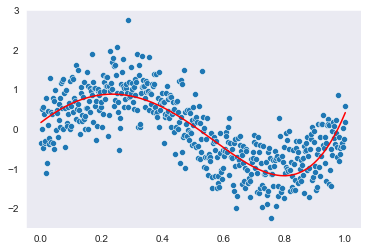

In [19]:
poly_reg.plot()

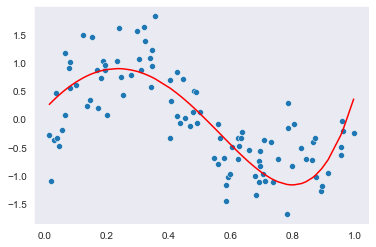

In [20]:
poly_reg.plot_test(X_test, y_test)

In [21]:
poly_reg.weight_vector()

array([[  0.17762266],
       [  5.96661871],
       [-11.56821476],
       [ -4.88865107],
       [  3.30833034],
       [  7.43097535]])

In [22]:
poly_reg.score(X_test, y_test)

0.6130856968881941

### Lasso Regularization

In [23]:
poly_reg_lasso = PolynomialRegression(X_train, y_train, alpha=1e-1, degree=5, reg='l1', lambda_reg=1)

In [24]:
poly_reg_lasso.batch_gradient_descent(num_iter=1e5)

Iterations:  100000


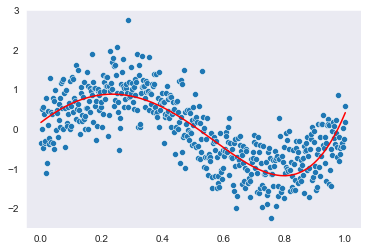

In [25]:
poly_reg_lasso.plot()

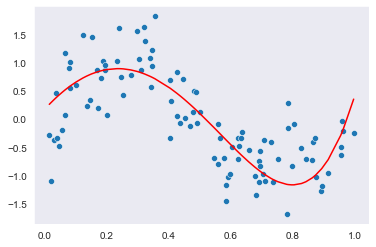

In [26]:
poly_reg_lasso.plot_test(X_test, y_test)

In [27]:
poly_reg_lasso.weight_vector()

array([[  0.1790168 ],
       [  5.95519668],
       [-11.55805716],
       [ -4.85814848],
       [  3.26623454],
       [  7.44137785]])

In [28]:
poly_reg_lasso.score(X_test, y_test)

0.6130310890480497

### Ridge Regularization

In [29]:
poly_reg_ridge = PolynomialRegression(X_train, y_train, alpha=1e-1, degree=5, reg='l2', lambda_reg=1)

In [30]:
poly_reg_ridge.batch_gradient_descent(num_iter=1e5)

Iterations:  100000


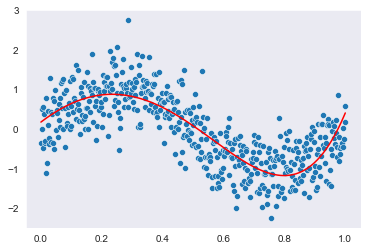

In [31]:
poly_reg_ridge.plot()

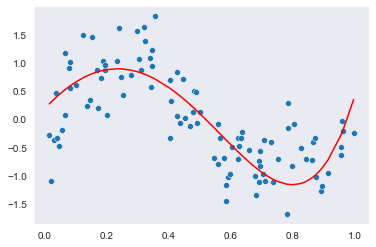

In [32]:
poly_reg_ridge.plot_test(X_test, y_test)

In [33]:
poly_reg_ridge.weight_vector()

array([[  0.18809476],
       [  5.87266784],
       [-11.41856413],
       [ -4.87279749],
       [  3.24167286],
       [  7.40729784]])

In [34]:
poly_reg_ridge.score(X_test, y_test)

0.6127195070529463